In [1]:
import zlib
import numpy as np
import torch
import torch.nn as nn
from torch import Tensor
from torchvision.transforms import ToPILImage
from compressai.layers import GDN1, conv1x1, conv3x3, AttentionBlock
from compressai.models import CompressionModel
from compressai.models.utils import deconv
from compressai.entropy_models import EntropyBottleneck
from datasets import load_dataset
from IPython.display import display

In [2]:
valid_dataset = load_dataset("danjacobellis/aria_ea_rgb_100k", split="validation").with_format("torch")

Resolving data files:   0%|          | 0/70 [00:00<?, ?it/s]

Resolving data files:   0%|          | 0/18 [00:00<?, ?it/s]

Resolving data files:   0%|          | 0/70 [00:00<?, ?it/s]

Resolving data files:   0%|          | 0/18 [00:00<?, ?it/s]

Loading dataset shards:   0%|          | 0/18 [00:00<?, ?it/s]

In [4]:
class ResidualBottleneckBlock(nn.Module):

    def __init__(self, in_ch: int, out_ch: int):
        super().__init__()
        mid_ch = min(in_ch, out_ch) // 2
        self.conv1 = conv1x1(in_ch, mid_ch)
        self.relu1 = nn.ReLU(inplace=True)
        self.conv2 = conv3x3(mid_ch, mid_ch)
        self.relu2 = nn.ReLU(inplace=True)
        self.conv3 = conv1x1(mid_ch, out_ch)
        self.skip = conv1x1(in_ch, out_ch) if in_ch != out_ch else nn.Identity()

    def forward(self, x: Tensor) -> Tensor:
        identity = self.skip(x)

        out = x
        out = self.conv1(out)
        out = self.relu1(out)
        out = self.conv2(out)
        out = self.relu2(out)
        out = self.conv3(out)

        return out + identity
        
class RateDistortionAutoEncoder(CompressionModel):
    def __init__(self, N=128):
        super().__init__()
        self.entropy_bottleneck = EntropyBottleneck(N)
        
        self.encode = nn.Sequential(
            nn.Conv2d(3, 8, stride=2, kernel_size=5, padding=2),
            GDN1(8),
            nn.Conv2d(8, 24, stride=2, kernel_size=5, padding=2),
            GDN1(24),
            nn.Conv2d(24, 72, stride=2, kernel_size=5, padding=2),
            GDN1(72),
            nn.Conv2d(72, N, stride=2, kernel_size=5, padding=2),
        )
        
        self.decode = nn.Sequential(
            AttentionBlock(N),
            deconv(N, N, kernel_size=5, stride=2),
            ResidualBottleneckBlock(N, N),
            ResidualBottleneckBlock(N, N),
            ResidualBottleneckBlock(N, N),
            deconv(N, N, kernel_size=5, stride=2),
            AttentionBlock(N),
            ResidualBottleneckBlock(N, N),
            ResidualBottleneckBlock(N, N),
            ResidualBottleneckBlock(N, N),
            deconv(N, N, kernel_size=5, stride=2),
            ResidualBottleneckBlock(N, N),
            ResidualBottleneckBlock(N, N),
            ResidualBottleneckBlock(N, N),
            deconv(N, 3, kernel_size=5, stride=2),
            torch.nn.Hardtanh(min_val=-0.5, max_val=0.5),
        )
        
    def forward(self, x):
        y = self.encode(x)
        y_hat, y_likelihoods = self.entropy_bottleneck(y)
        x_hat = self.decode(y_hat)
        return x_hat, y_likelihoods

def lossy_analysis_transform(x):
    z = model.encode(x).round().to(torch.int8).detach().cpu().numpy()
    return z
    
def lossless_entropy_encode(z):
    original_shape = z.shape
    compressed_img = zlib.compress(z.tobytes(), level=9)
    return compressed_img, original_shape

def compress(img):
    z = lossy_analysis_transform(img)
    compressed_img, original_shape = lossless_entropy_encode(z)
    return compressed_img, original_shape

def entropy_decoder(compressed_img,original_shape):
    decompressed = zlib.decompress(compressed_img)
    ẑ = np.frombuffer(decompressed, dtype=np.int8)
    ẑ = ẑ.reshape(original_shape)
    return ẑ
    
def synthesis_transform(ẑ, device):
    ẑ = torch.tensor(ẑ).to(torch.float).to(device)
    x̂ = model.decode(ẑ).detach().cpu()
    return x̂
    
def decompress(compressed_img, original_shape, device="cpu"):
    ẑ = entropy_decoder(compressed_img,original_shape)
    x̂ = synthesis_transform(ẑ, device)
    return x̂

def preprocess(img_or_batch, device="cpu"):
    if img_or_batch.ndim == 3:
        x = img_or_batch.unsqueeze(0)
    else:
        x = img_or_batch

    x = x.to(torch.float)
    x = x/255
    x = x-0.5
    x = x.permute(0, 3, 1, 2)
    x = x.rot90(k=3,dims=[2,3])
    x = x.to(device)
        
    return x

def postprocess(batch):
    pil = ToPILImage()
    return [pil(img+0.5) for img in batch]

In [5]:
device = "cpu"
model = RateDistortionAutoEncoder()
checkpoint = torch.load("v1.pth")
model.load_state_dict(checkpoint['model_state_dict'])
model = model.to(device)

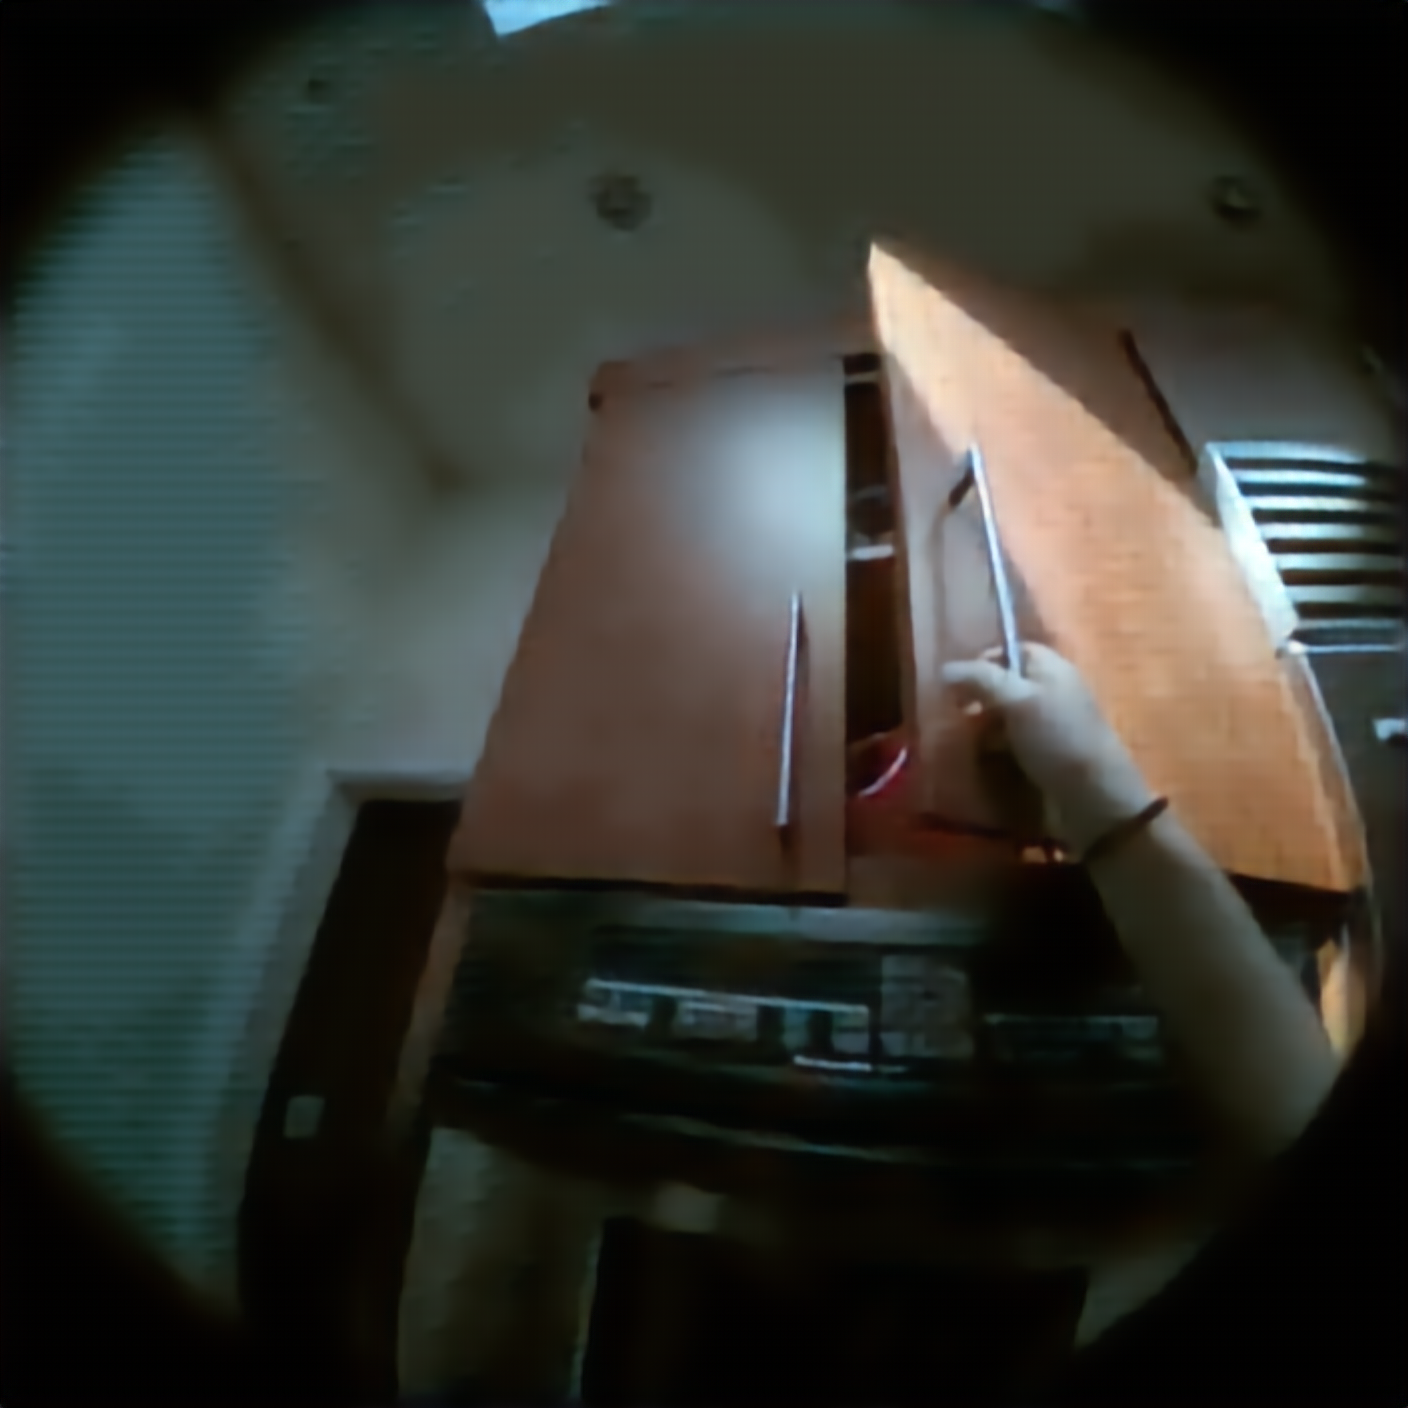

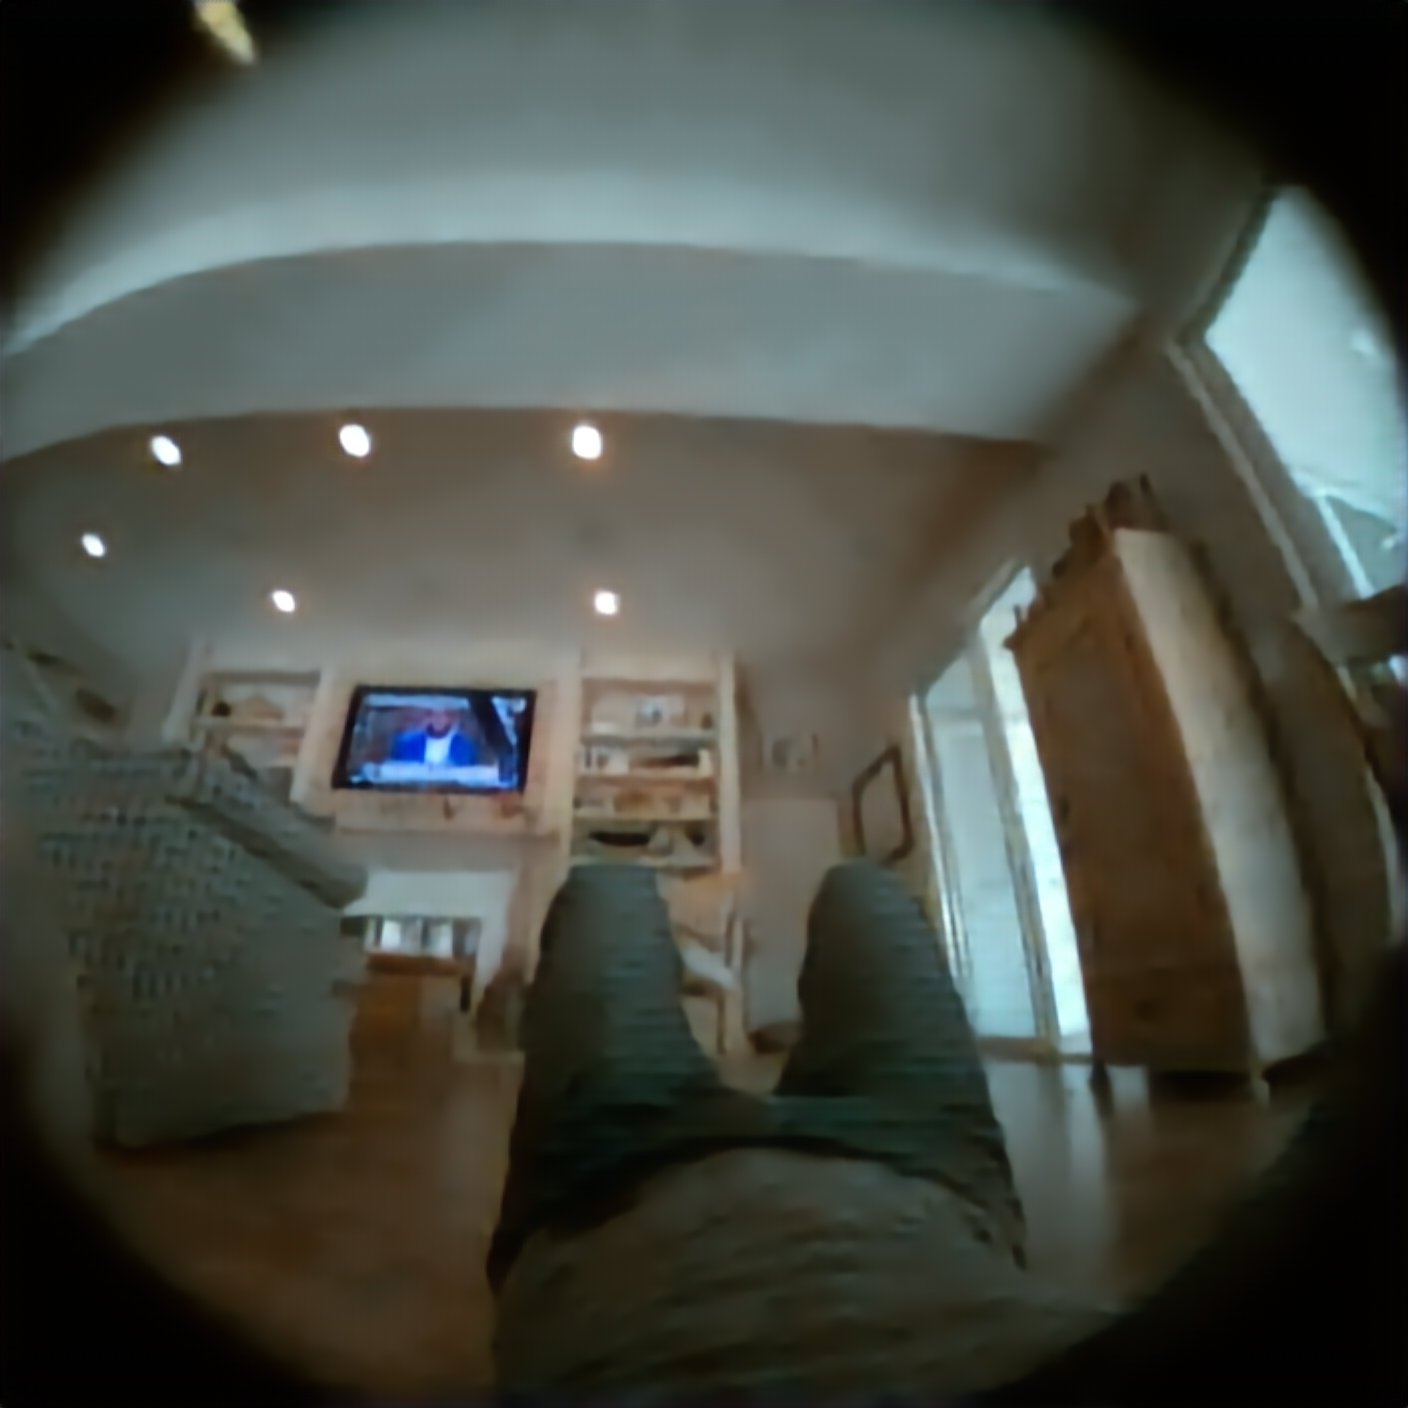

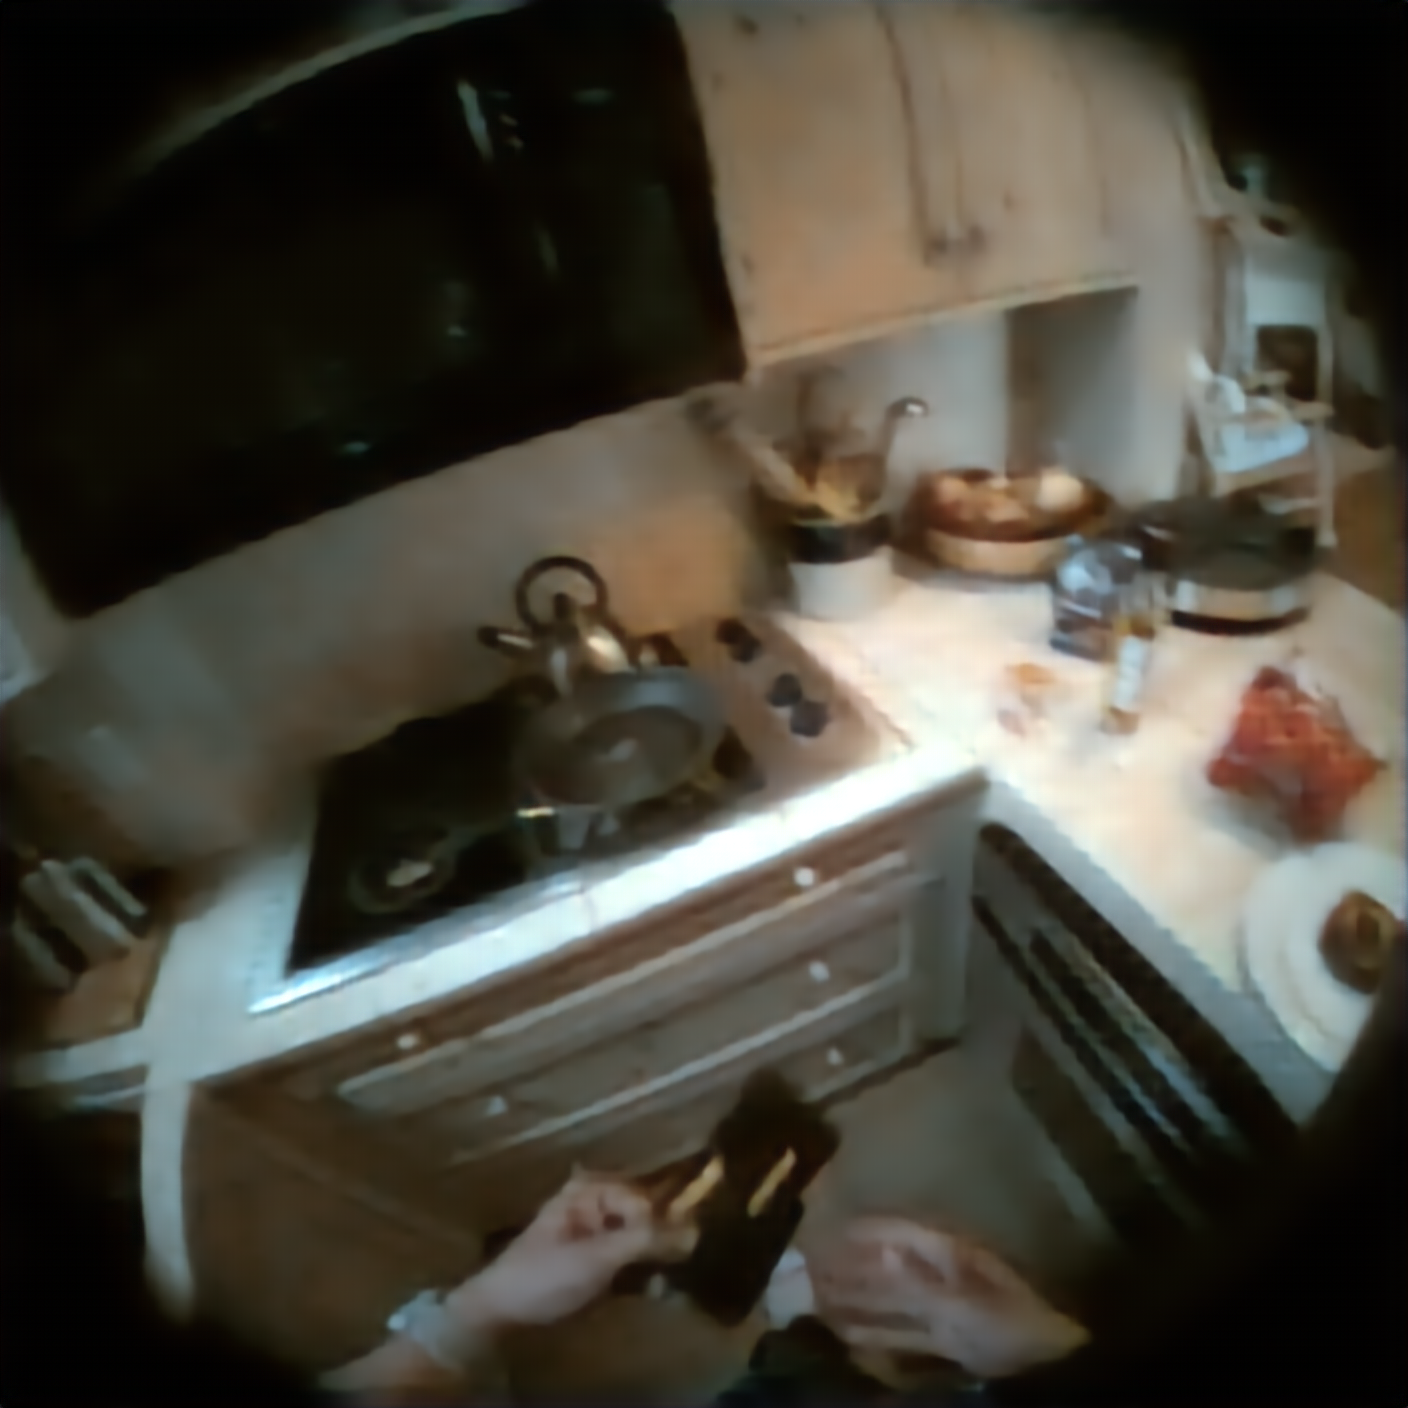

In [6]:
test_batch = preprocess(valid_dataset[[1000,3000,6000]]['image'], device)
compressed_img, original_shape = compress(test_batch)
rec = decompress(compressed_img, original_shape, device)
for img in postprocess(rec):
    display(img)